# This is going to be awesome

### Imports

In [279]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [280]:
colors = ['#BDDDFC', '#88BDF2', '#6A89A7', '#384959']
color_palett = ListedColormap(sns.color_palette(['#BDDDFC', '#AAC8E5', '#97B3CD', '#849EB6', '#71889F', '#5E7388', '#4B5E70', '#384959']))

In [281]:
pre = pd.read_csv('data/pre.csv', quotechar='\t')
during = pd.read_csv('data/during.csv', quotechar='\t')
post = pd.read_csv('data/post.csv', quotechar='\t')
pre.columns

Index(['"Timestamp', '""Participant ID (top-right corner of the screen)""',
       '""How old are you?""', '""Gender?""',
       '""What describes you the best?""',
       '""How comfortable are you in expressing emotions?""',
       '""Have you ever played with the drummer bot dB before?""',
       '""How much prior experience do you have with interactive musical interfaces (e.g. sensor systems. digital control devices)?""',
       '""How often do you use AI tools for creativity (e.g. writing. coding. music. fine arts. food recipes. etc.)?""',
       '""Please indicate if you have any of the following health problems.""";'],
      dtype='object')

### Filter data

In [282]:
# inspect for test data
mask = np.column_stack([pre[col].str.contains('test', na=False) for col in pre])
print(pre[mask])

mask = np.column_stack([pre[col].str.contains('Test', na=False) for col in pre])
print(pre[mask])

                        "Timestamp  \
0     "2024/11/04 5:15:10 PM GMT+1   
50    "2024/11/07 2:09:46 PM GMT+1   
63   "2024/11/08 12:47:28 PM GMT+1   
128  "2024/11/11 11:03:28 AM GMT+1   
131  "2024/11/11 11:29:10 AM GMT+1   
135  "2024/11/11 11:55:54 AM GMT+1   
137  "2024/11/11 12:11:12 PM GMT+1   
140  "2024/11/11 12:33:52 PM GMT+1   

    ""Participant ID (top-right corner of the screen)"" ""How old are you?""  \
0                                             ""test""                ""66""   
50                                      ""kuromitest""                ""23""   
63                                            ""test""                ""24""   
128                                   ""group8_test1""                ""25""   
131                                        ""8_test1""                ""25""   
135                                        ""8_test3""                ""22""   
137                                     ""8_testing3""                ""22""   
140              

In [283]:
## drop test data
pre = pre.drop(index=[0, 1, 63, 128, 131, 135])

In [284]:
## rename columns and remove quotes

pre_columns = pre.columns
pre_data = pre[[pre_columns[1], pre_columns[2], pre_columns[3], pre_columns[4], pre_columns[5]]]
pre_data.columns = ['Participant_ID', 'Age', 'Gender', 'Personal description', 'Comfortable with expressing emotions']
pre_data = pre_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

during_columns = during.columns
during_data = during[[during_columns[1], during_columns[2], during_columns[4], during_columns[5]]]
during_data.columns = ['Session_ID', 'Participant_ID', 'Annoyance', 'Excitement']
during_data = during_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

post_columns = post.columns
post_data = post[[post_columns[1], post_columns[3], post_columns[7]]]
post_data.columns = ['Participant_ID', 'Control', 'Creative expression']
post_data = post_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

In [285]:
## Remove participants according to the instructions
pre_data = pre_data[~pre_data['Participant_ID'].isin(['grup16', 'group15a', 'group15b', 'group15c'])]
during_data = during_data[~during_data['Participant_ID'].isin(['grup16', 'group15a', 'group15b', 'group15c'])]
post_data = post_data[~post_data['Participant_ID'].isin(['grup16', 'group15a', 'group15b', 'group15c'])]

In [286]:
## check session ID
print(during_data['Session_ID'].unique())

['ILLIAC' 'CYSP' 'VOYAGER' 'ALICE' 'Alice' 'illiac' 'voyager' 'cysp'
 'alice' '1' '3' '2' '4' 'ALLICE' 'iliac' 'ILLIAD' 'Crysp' 'Voyager'
 'Cysp' 'group18_j1_1' 'group18_j1_2' 'group18_j1_3' 'group18_j1_4'
 'Illiac' ' ALICE' 'x' ' VOYAGER']


In [287]:
## Fix session naming
during_data['Session_ID'] = during_data['Session_ID'].str.upper()
during_data['Session_ID'] = during_data['Session_ID'].replace('ALLICE', 'ALICE')
during_data['Session_ID'] = during_data['Session_ID'].replace(' ALICE', 'ALICE')
during_data['Session_ID'] = during_data['Session_ID'].replace('ILIAC', 'ILLIAC')
during_data['Session_ID'] = during_data['Session_ID'].replace('ILLIAD', 'ILLIAC')
during_data['Session_ID'] = during_data['Session_ID'].replace('CRYSP', 'CYSP')
during_data['Session_ID'] = during_data['Session_ID'].replace(' VOYAGER', 'VOYAGER')

## Delete all rows with an incorrect session name
during_data = during_data[during_data['Session_ID'].isin(['ALICE', 'ILLIAC', 'CYSP', 'VOYAGER'])]
print(during_data['Session_ID'].unique(), during_data.nunique())

['ILLIAC' 'CYSP' 'VOYAGER' 'ALICE'] Session_ID          4
Participant_ID    108
Annoyance           5
Excitement          5
dtype: int64


In [288]:
## remove duplicates if any
pre_data = pre_data.drop_duplicates(subset=['Participant_ID'], keep='first')
during_data = during_data.drop_duplicates(subset=['Participant_ID', 'Session_ID'], keep='first')
post_data = post_data.drop_duplicates(subset=['Participant_ID'], keep='first')


In [289]:
print(pre_data.shape)
print(pre_data.nunique())
print(during_data.shape)
print(during_data.nunique())
print(post_data.shape)
print(post_data.nunique())

(119, 5)
Participant_ID                          119
Age                                      28
Gender                                    2
Personal description                      5
Comfortable with expressing emotions      5
dtype: int64
(385, 4)
Session_ID          4
Participant_ID    108
Annoyance           5
Excitement          5
dtype: int64
(111, 3)
Participant_ID         111
Control                  5
Creative expression      5
dtype: int64


### Match data based on Participant ID

In [290]:
df = pre_data.merge(post_data, on='Participant_ID', how='outer', indicator=True)
only_pre = df[df['_merge'] == 'left_only']
only_post = df[df['_merge'] == 'right_only']
both = df[df['_merge'] == 'both']
print(both.shape)
both.head()

(109, 8)


,Participant_ID,Age,Gender,Personal description,Comfortable with expressing emotions,Control,Creative expression,_merge
0,andsti-01,25,Male,Avid music listener,2,1,2,both
1,andsti-02,25,Female,Student/semi-professional musician,0,1,1,both
4,Aos,11,Male,Not particularly interested in music,4,2,4,both
5,andsti-03,22,Female,Avid music listener,4,1,2,both
6,andsti-04,24,Female,Averagely interested in music,3,1,2,both


In [291]:
df_all = pd.merge(both, during_data, on='Participant_ID', how='inner')
df_all = df_all.replace(['0', '1', '2', '3', '4', '5'], [0, 1, 2, 3, 4, 5])
df_all

,Participant_ID,Age,Gender,Personal description,Comfortable with expressing emotions,Control,Creative expression,_merge,Session_ID,Annoyance,Excitement
0,andsti-01,25,Male,Avid music listener,2,1,2,both,ILLIAC,2,3
1,andsti-01,25,Male,Avid music listener,2,1,2,both,CYSP,2,1
2,andsti-01,25,Male,Avid music listener,2,1,2,both,VOYAGER,2,1
3,andsti-01,25,Male,Avid music listener,2,1,2,both,ALICE,3,1
4,andsti-02,25,Female,Student/semi-professional musician,0,1,1,both,ALICE,4,0
...,...,...,...,...,...,...,...,...,...,...,...
369,8_testing4,30,Female,Professional musician,4,1,2,both,CYSP,1,1
370,6_5,25,Female,Averagely interested in music,3,2,1,both,ILLIAC,3,1
371,6_5,25,Female,Averagely interested in music,3,2,1,both,CYSP,1,2
372,6_5,25,Female,Averagely interested in music,3,2,1,both,ALICE,2,1


In [292]:
non_comfortable = df_all[df_all['Comfortable with expressing emotions'] < 3]
comfortable = df_all[df_all['Comfortable with expressing emotions'] >= 3]

grouped_df_all = df_all.copy()
grouped_df_all['Comfortable with expressing emotions'] = grouped_df_all['Comfortable with expressing emotions'].replace([0, 1, 2], 'Not comfortable')
grouped_df_all['Comfortable with expressing emotions'] = grouped_df_all['Comfortable with expressing emotions'].replace([3, 4, 5], 'Comfortable')

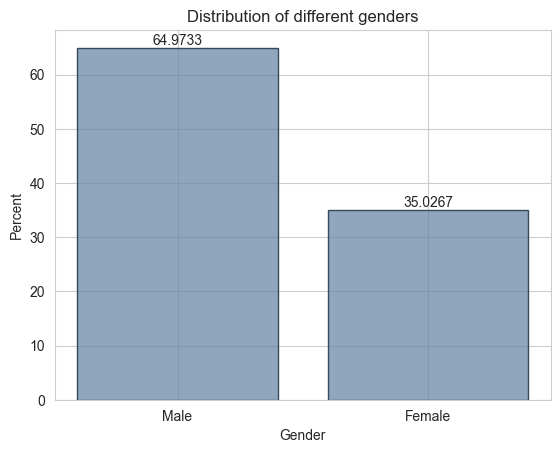

In [293]:
ax = sns.histplot(df_all['Gender'], color=colors[2], shrink=0.8, edgecolor=colors[-1], stat='percent')
ax.set_title('Distribution of different genders')
ax.bar_label(ax.containers[0])
plt.show()

In [294]:
str_numbers = [str(i) for i in range(100)]
numbers = [i for i in range(100)]
df_all['Age'] = df_all['Age'].replace(str_numbers, numbers)
m = df_all['Age'].mean()
s = df_all['Age'].std()
print(f'For the whole dataset:\nMean: {m:.3f}\nStandard Deviation: {s:.3f}\n')

comfortable['Age'] = comfortable['Age'].replace(str_numbers, numbers)
non_comfortable['Age'] = non_comfortable['Age'].replace(str_numbers, numbers)
m = comfortable['Age'].mean()
s = comfortable['Age'].std()
print(f'For comfortable people:\nMean: {m:.3f}\nStandard Deviation: {s:.3f}\n')
m = non_comfortable['Age'].mean()
s = non_comfortable['Age'].std()
print(f'For non-comfortable people:\nMean: {m:.3f}\nStandard Deviation: {s:.3f}\n')

For the whole dataset:
Mean: 26.444
Standard Deviation: 9.622

For comfortable people:
Mean: 25.158
Standard Deviation: 7.979

For non-comfortable people:
Mean: 28.182
Standard Deviation: 11.272



/var/folders/np/z3d7fsz132vckb3gj8c2j2c00000gn/T/ipykernel_26787/2969386396.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comfortable['Age'] = comfortable['Age'].replace(str_numbers, numbers)
/var/folders/np/z3d7fsz132vckb3gj8c2j2c00000gn/T/ipykernel_26787/2969386396.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_comfortable['Age'] = non_comfortable['Age'].replace(str_numbers, numbers)


/var/folders/np/z3d7fsz132vckb3gj8c2j2c00000gn/T/ipykernel_26787/1077853705.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=60)


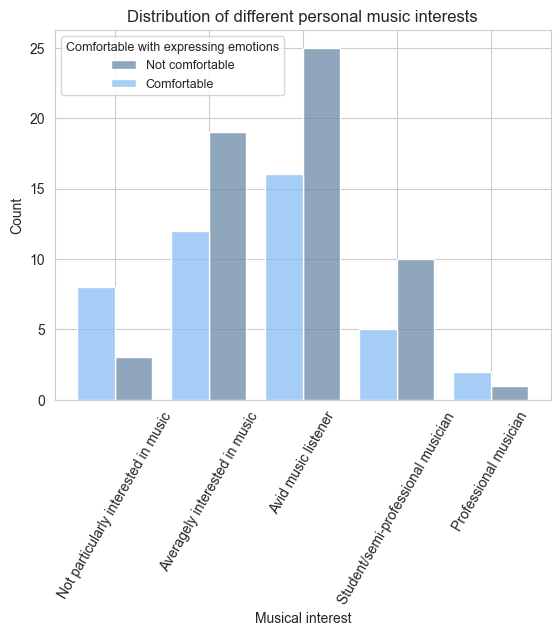

In [295]:
order = [
    'Not particularly interested in music', 
    'Averagely interested in music', 
    'Avid music listener', 
    'Student/semi-professional musician', 
    'Professional musician']

to_plot = grouped_df_all.copy()
to_plot = to_plot.drop_duplicates(subset='Participant_ID')
to_plot['Personal description'] = pd.Categorical(to_plot['Personal description'], categories=order, ordered=True)

ax = sns.histplot(data=to_plot, x='Personal description', hue='Comfortable with expressing emotions', palette=colors[1:3], multiple="dodge", shrink=0.8, zorder=3)
ax.set_title('Distribution of different personal music interests')
ax.set_xlabel('Musical interest')
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.grid(True, zorder=0)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])
plt.show()

<Axes: >

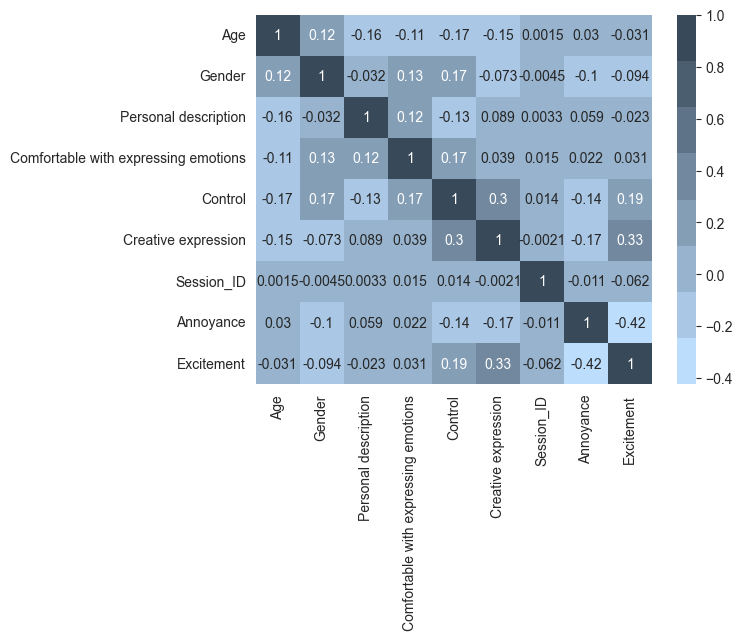

In [296]:
df_all_numeric = df_all.replace(['ILLIAC', 'CYSP', 'ALICE', 'VOYAGER'], [0, 1, 2, 3])
df_all_numeric = df_all_numeric.replace(order, [0, 1, 2, 3, 4])
df_all_numeric = df_all_numeric.replace(['Male', 'Female'], [0, 1])
df_all_numeric = df_all_numeric.drop(['Participant_ID', '_merge'], axis=1)
df_all_numeric = df_all_numeric.replace(['0', '1', '2', '3', '4', '5'], [0, 1, 2, 3, 4, 5])

sns.heatmap(df_all_numeric.corr(), annot=True, cmap=color_palett)

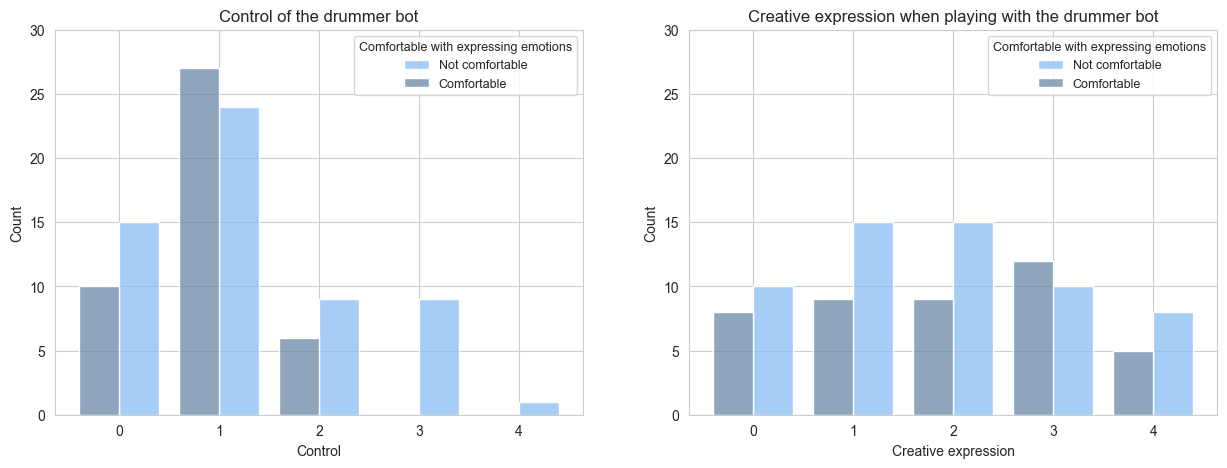

In [297]:
# Control and creative experience
to_plot = to_plot.replace([0, 1, 2, 3, 4, 5], ['0', '1', '2', '3', '4', '5'])
order = ['0', '1', '2', '3', '4', '5']
to_plot['Control'] = pd.Categorical(to_plot['Control'], categories=order, ordered=True)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=to_plot, x='Control', hue='Comfortable with expressing emotions', ax=axs[0], palette=[colors[2], colors[1]], multiple="dodge", shrink=0.8, zorder=3)
axs[0].set_ylim(0, 30)
axs[0].set_title('Control of the drummer bot')
axs[0].legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])

to_plot['Creative expression'] = pd.Categorical(to_plot['Creative expression'], categories=order, ordered=True)
sns.histplot(data=to_plot, x='Creative expression', hue='Comfortable with expressing emotions', ax=axs[1], palette=[colors[2], colors[1]], multiple="dodge", shrink=0.8, zorder=3)
axs[1].set_ylim(0, 30)
axs[1].set_title('Creative expression when playing with the drummer bot')
axs[1].legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])

plt.show()

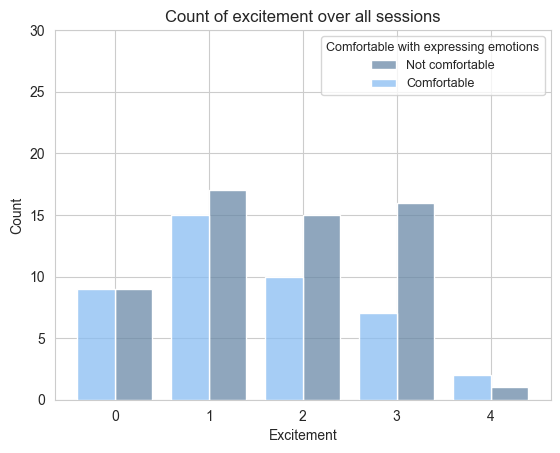

In [298]:
to_plot['Excitement'] = pd.Categorical(to_plot['Excitement'], categories=order, ordered=True)

ax = sns.histplot(data=to_plot, x='Excitement', hue='Comfortable with expressing emotions', palette=colors[1:3], multiple="dodge", shrink=0.8, zorder=3)
ax.set_title('Count of excitement over all sessions')
ax.set_xlabel('Excitement')
ax.set_ylim(0, 30)
ax.grid(True, zorder=0)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])
plt.show()

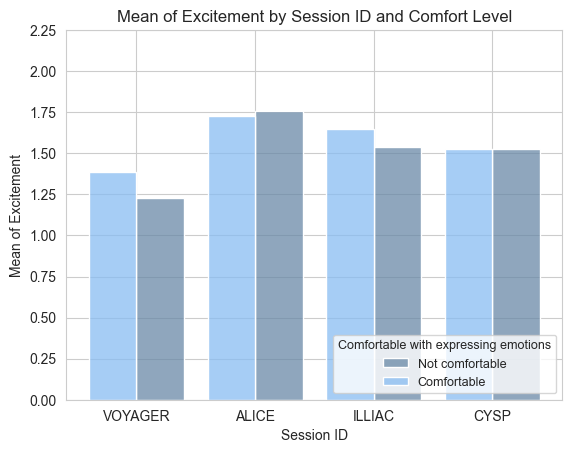

In [299]:
aggregated_data = grouped_df_all.groupby(['Session_ID', 'Comfortable with expressing emotions'], as_index=False)['Excitement'].mean()

order = ['VOYAGER', 'ALICE', 'ILLIAC', 'CYSP']
aggregated_data['Session_ID'] = pd.Categorical(aggregated_data['Session_ID'], categories=order, ordered=True)

sns.set_style('whitegrid')
ax = sns.histplot(data=aggregated_data, x='Session_ID', weights='Excitement', hue='Comfortable with expressing emotions', discrete=True, multiple='dodge', palette=colors[1:3], shrink=0.8)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'], loc='lower right')
ax.set_ylabel("Mean of Excitement")
ax.set_xlabel("Session ID")
ax.set_title("Mean of Excitement by Session ID and Comfort Level")
ax.set_ylim(0, 2.25)
plt.show()


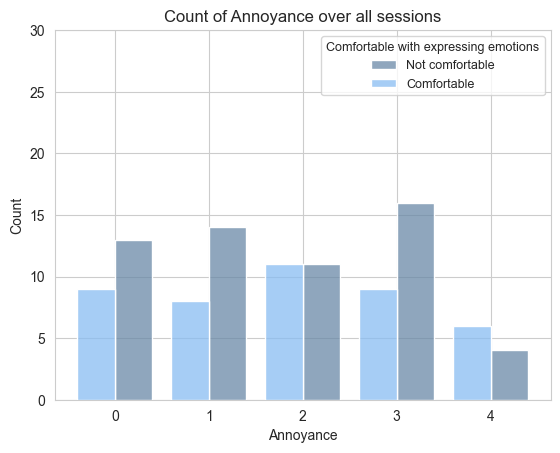

In [300]:
order = ['0', '1', '2', '3', '4', '5']
to_plot['Annoyance'] = pd.Categorical(to_plot['Annoyance'], categories=order, ordered=True)

ax = sns.histplot(data=to_plot, x='Annoyance', hue='Comfortable with expressing emotions', multiple="dodge", palette=colors[1:3], shrink=0.8, zorder=3)
ax.set_title('Count of Annoyance over all sessions')
ax.set_xlabel('Annoyance')
ax.set_ylim(0, 30)
ax.grid(True, zorder=0)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])
plt.show()

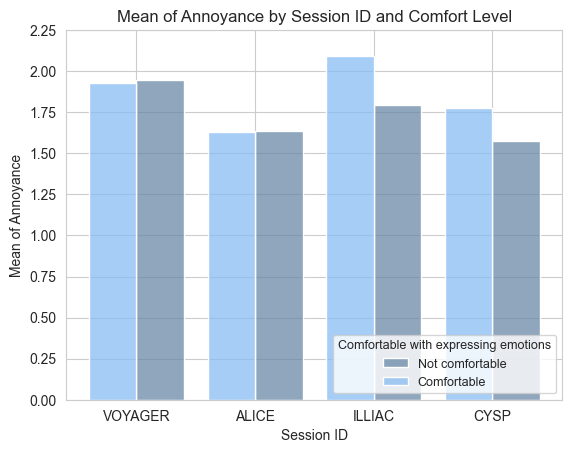

In [301]:
aggregated_data = grouped_df_all.groupby(['Session_ID', 'Comfortable with expressing emotions'], as_index=False)['Annoyance'].mean()

order = ['VOYAGER', 'ALICE', 'ILLIAC', 'CYSP']
aggregated_data['Session_ID'] = pd.Categorical(aggregated_data['Session_ID'], categories=order, ordered=True)

sns.set_style('whitegrid')
ax = sns.histplot(data=aggregated_data, x='Session_ID', weights='Annoyance', hue='Comfortable with expressing emotions', discrete=True, multiple='dodge', palette=colors[1:3], shrink=0.8)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'], loc='lower right')
ax.set_ylabel("Mean of Annoyance")
ax.set_xlabel("Session ID")
ax.set_title("Mean of Annoyance by Session ID and Comfort Level")
ax.set_ylim(0, 2.25)
plt.show()

### ANOVA analysis

In [302]:
# Excitement
f_statistic, p_value = stats.f_oneway(non_comfortable['Excitement'], comfortable['Excitement'])

print(f'F-statistic: {f_statistic:.3f}')
print(f'P-value: {p_value:.3f} > 0.05')

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=grouped_df_all['Excitement'], groups=grouped_df_all['Comfortable with expressing emotions'], alpha=0.05)
print(tukey.summary())

F-statistic: 0.181
P-value: 0.671 > 0.05
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1        group2     meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
Comfortable Not comfortable  -0.0517 0.6708 -0.2908 0.1873  False
-----------------------------------------------------------------


In [303]:
# Excitement
f_statistic, p_value = stats.f_oneway(non_comfortable['Annoyance'], comfortable['Annoyance'])

print(f'F-statistic: {f_statistic:.3f}')
print(f'P-value: {p_value:.3f} > 0.05')

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=grouped_df_all['Annoyance'], groups=grouped_df_all['Comfortable with expressing emotions'], alpha=0.05)
print(tukey.summary())

F-statistic: 0.799
P-value: 0.372 > 0.05
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1        group2     meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
Comfortable Not comfortable  -0.1246 0.3719 -0.3987 0.1495  False
-----------------------------------------------------------------


In [304]:
# Control
f_statistic, p_value = stats.f_oneway(non_comfortable['Control'], comfortable['Control'])

print(f'F-statistic: {f_statistic:.3f}')
print(f'P-value: {p_value:.3f} < 0.05')

tukey = pairwise_tukeyhsd(endog=grouped_df_all['Control'], groups=grouped_df_all['Comfortable with expressing emotions'], alpha=0.05)
print(tukey.summary())

F-statistic: 14.422
P-value: 0.000 < 0.05
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1        group2     meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
Comfortable Not comfortable  -0.3545 0.0002 -0.5381 -0.171   True
-----------------------------------------------------------------


In [305]:
# Creative expression
f_statistic, p_value = stats.f_oneway(non_comfortable['Creative expression'], comfortable['Creative expression'])

print(f'F-statistic: {f_statistic:.3f}')
print(f'P-value: {p_value:.3f} > 0.05')

tukey = pairwise_tukeyhsd(endog=grouped_df_all['Creative expression'], groups=grouped_df_all['Comfortable with expressing emotions'], alpha=0.05)
print(tukey.summary())

F-statistic: 0.229
P-value: 0.632 > 0.05
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1        group2     meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
Comfortable Not comfortable   0.0643 0.6323 -0.1998 0.3284  False
-----------------------------------------------------------------


In [306]:
# Gender
comfortable_gender = comfortable.replace(['Male', 'Female'], [0, 1])
non_comfortable_gender = non_comfortable.replace(['Male', 'Female'], [0, 1])
f_statistic, p_value = stats.f_oneway(non_comfortable_gender['Gender'], comfortable_gender['Gender'])

print(f'F-statistic: {f_statistic:.3f}')
print(f'P-value: {p_value:.3f} < 0.05')

grouped_df_all_grouped = grouped_df_all.replace(['Male', 'Female'], [0, 1])
tukey = pairwise_tukeyhsd(endog=grouped_df_all_grouped['Gender'], groups=grouped_df_all_grouped['Comfortable with expressing emotions'], alpha=0.05)
print(tukey.summary())

F-statistic: 21.666
P-value: 0.000 < 0.05
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1        group2     meandiff p-adj lower   upper  reject
----------------------------------------------------------------
Comfortable Not comfortable  -0.2264   0.0 -0.322 -0.1308   True
----------------------------------------------------------------


In [307]:
# Session ID and excitement
alice = df_all[df_all['Session_ID'] == 'ALICE']
illiac = df_all[df_all['Session_ID'] == 'ILLIAC']
cysp = df_all[df_all['Session_ID'] == 'CYSP']
voyager = df_all[df_all['Session_ID'] == 'VOYAGER']

f_statistic, p_value = stats.f_oneway(alice['Excitement'], illiac['Excitement'], cysp['Excitement'], voyager['Excitement'])

print(f'F-statistic: {f_statistic:.3f}')
print(f'P-value: {p_value:.3f} > 0.05')

F-statistic: 2.130
P-value: 0.096 > 0.05


In [308]:
# Session ID and annoyance
f_statistic, p_value = stats.f_oneway(alice['Annoyance'], illiac['Annoyance'], cysp['Annoyance'], voyager['Annoyance'])

print(f'F-statistic: {f_statistic:.3f}')
print(f'P-value: {p_value:.3f} > 0.05')

F-statistic: 1.550
P-value: 0.201 > 0.05


## Notes from presentations


 * Heatmap could be a good supply?
 * Need to provide a confidence interval (ours is 95%)
 * Need much information about data to get a overview of the whole data set
 * Group pro and semi-pro in the start of the analysis and argue why we do it
 * Maybe we can add another question from the during questionaires?
 * Can explain more how the user studies were conducted
 * ! Balance in the data !